In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
plt.style.use('seaborn-bright')
from statsmodels.tsa.seasonal import seasonal_decompose
import statsmodels.graphics.tsaplots as sgt
import statsmodels.tsa.stattools as sts
from statsmodels.stats.stattools import durbin_watson
from statsmodels.tsa.api import VAR
from statsmodels.tsa.api import VECM
from statsmodels.tsa.vector_ar.vecm import select_coint_rank
from statsmodels.tsa.vector_ar.vecm import coint_johansen
from statsmodels.tsa.statespace.varmax import VARMAX
from sklearn import metrics
from sklearn.model_selection import ParameterGrid
import scipy
import statsmodels.api as sm
from statsmodels.tsa.api import VAR
from statsmodels.tsa.base import  datetools

<ipython-input-66-858f07bc1350>:6: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-bright')


In [ ]:
mdata = sm.datasets.macrodata.load_pandas().data
mdata.head()
macro_dataframe=mdata.copy()

**Creating DateTime Objects**

In [ ]:
macro_dataframe.head(2)

,year,quarter,realgdp,realcons,realinv,realgovt,realdpi,cpi,m1,tbilrate,unemp,pop,infl,realint
0,1959.0,1.0,2710.349,1707.4,286.898,470.045,1886.9,28.98,139.7,2.82,5.8,177.146,0.00,0.00
1,1959.0,2.0,2778.801,1733.7,310.859,481.301,1919.7,29.15,141.7,3.08,5.1,177.830,2.34,0.74


In [ ]:
mdata=mdata[['year','quarter']].astype(int)
mdata=mdata[['year','quarter']].astype(str)
quarterly=mdata["year"] + "Q" + mdata["quarter"]
quarterly=datetools.dates_from_str(quarterly)

In [ ]:
macro_dataframe=macro_dataframe[['realgdp','realcons','realinv','realgovt','realdpi','cpi','realint','unemp']]
macro_dataframe.index=pd.DatetimeIndex(quarterly)
macro_dataframe.head()

,realgdp,realcons,realinv,realgovt,realdpi,cpi,realint,unemp
1959-03-31,2710.349,1707.4,286.898,470.045,1886.9,28.98,0.00,5.8
1959-06-30,2778.801,1733.7,310.859,481.301,1919.7,29.15,0.74,5.1
1959-09-30,2775.488,1751.8,289.226,491.260,1916.4,29.35,1.09,5.3
1959-12-31,2785.204,1753.7,299.356,484.052,1931.3,29.37,4.06,5.6
1960-03-31,2847.699,1770.5,331.722,462.199,1955.5,29.54,1.19,5.2


**Plotting the Time Series Dataset**

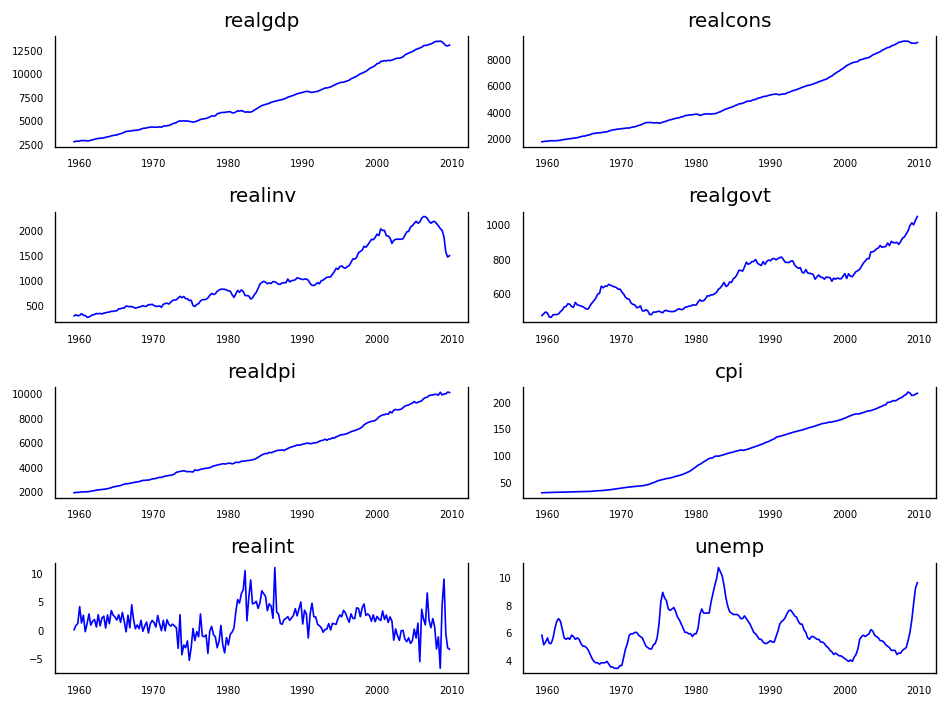

In [ ]:
fig,axes=plt.subplots(nrows=4,ncols=2,dpi=120,figsize=(8,6))
for i,ax in enumerate(axes.flatten()):
    data=macro_dataframe[macro_dataframe.columns[i]]
    ax.plot(data, color='blue', linewidth=1)
    ax.set_title(macro_dataframe.columns[i])
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    ax.spines["top"].set_alpha(0)
    ax.tick_params(labelsize=6)
plt.tight_layout();

Observations:
1) Visually we can see there are some trends and seasonality in data
2) To specifically check those trends we will look at seasonal Decompose values of the time series columns

**Seasonal Decompose**
An additive model suggests that the components are added together as follows:
y(t) = Level + Trend + Seasonality + Noise

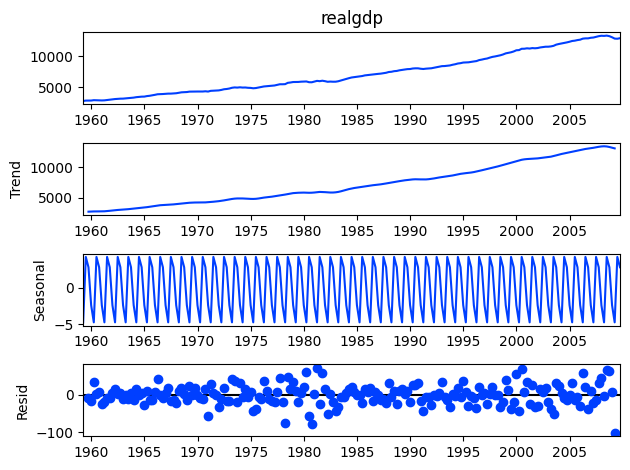

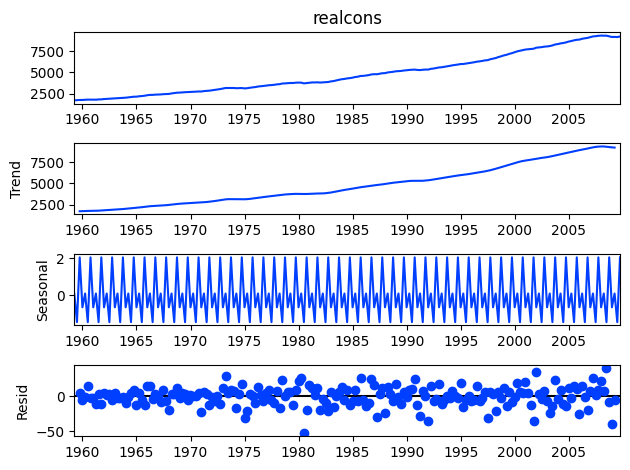

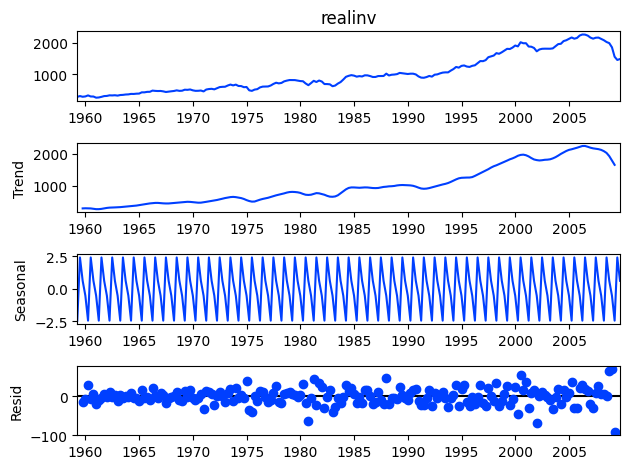

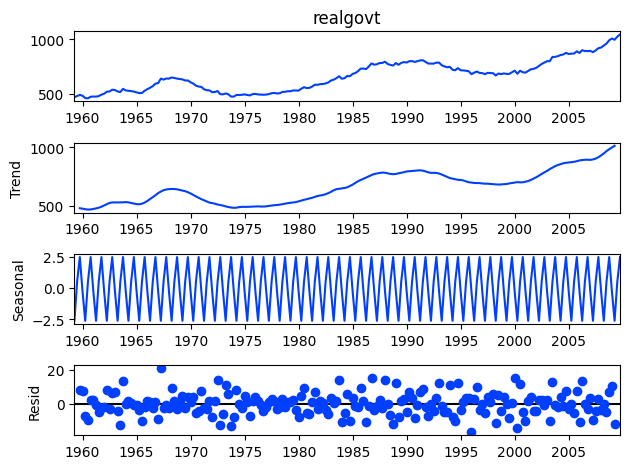

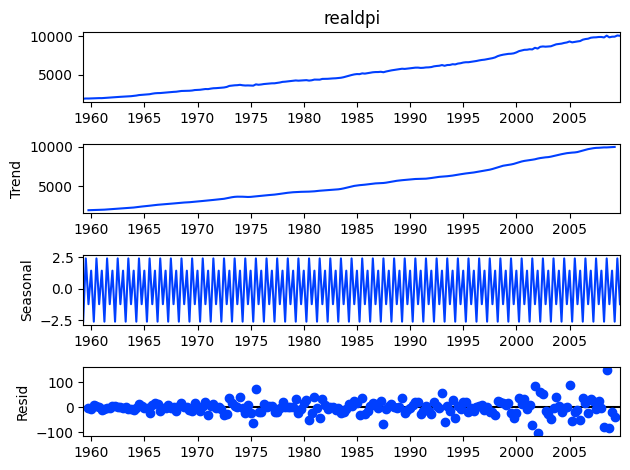

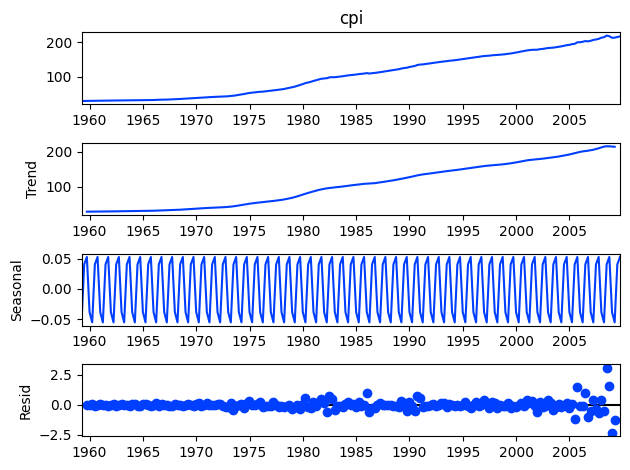

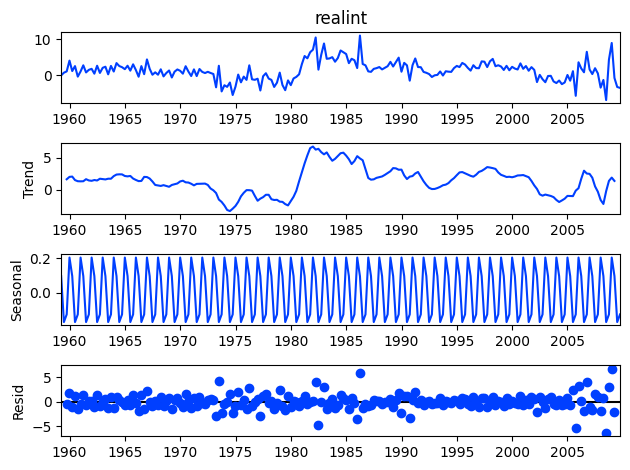

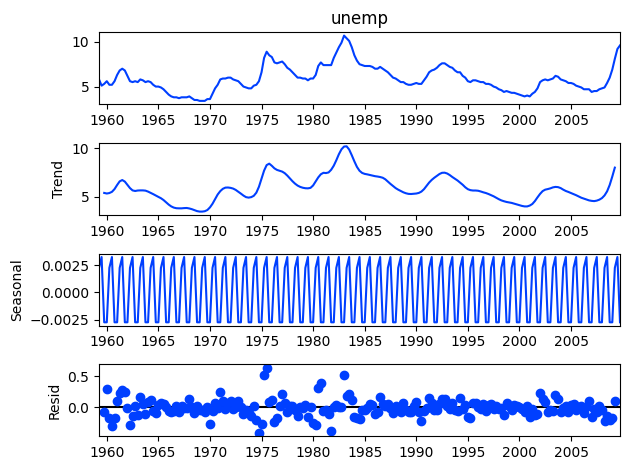

In [ ]:
for i, ax in enumerate(axes.flatten()):
    data=seasonal_decompose(macro_dataframe[macro_dataframe.columns[i]], model= 'additive')
    ax = data.plot()
plt.tight_layout();

Observations
1) From the above graphs we can see that there is trends and sesaonality in most attributes.
2)If the residuals of a seasonal decomposition are centered around the mean and show no patterns, it indicates that the decomposition model has captured most of the underlying seasonality and trend in the data

**Plotting ACF and PACF and testing for Stationarity**
1) The variables used can be realgdp, realcons, realinv

ACF stands for Autocorrelation Function, which measures the correlation between a time series and its lagged values. Specifically, it computes the correlation between the series at time t and the series at time t-k, where k is the lag. ACF is useful in identifying the order of an Autoregressive (AR) model.

PACF stands for Partial Autocorrelation Function, which measures the correlation between a time series and its lagged values, after removing the effects of the intervening lagged variables. Specifically, it computes the correlation between the series at time t and the series at time t-k, after removing the effects of the series at all intermediate lags between t and t-k. PACF is useful in identifying the order of a Moving Average (MA) model.

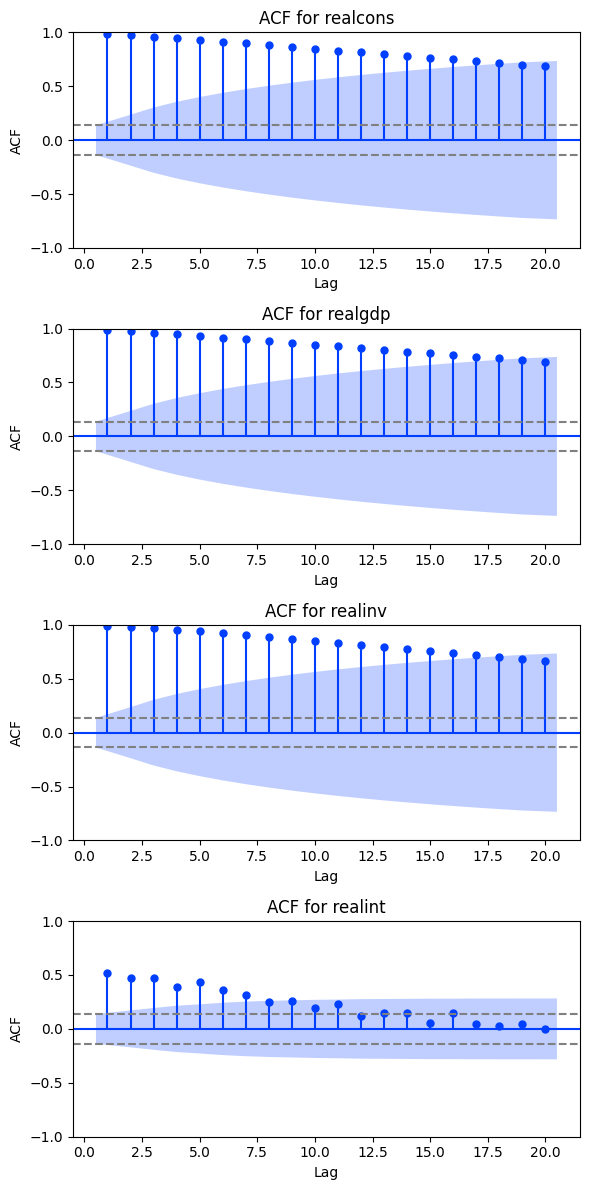

In [ ]:
import statsmodels.graphics.tsaplots as sgt
import matplotlib.pyplot as plt
col_list = ['realcons', 'realgdp', 'realinv','realint']
fig, axes = plt.subplots(nrows=len(col_list), ncols=1, figsize=(6,12))
for i, col in enumerate(col_list):
  sgt.plot_acf(macro_dataframe[col], lags=20, zero=False, ax=axes[i])
  axes[i].axhline(y=1.96/np.sqrt(len(macro_dataframe[col])), linestyle='--', color='gray')
  axes[i].axhline(y=-1.96/np.sqrt(len(macro_dataframe[col])), linestyle='--', color='gray')
  axes[i].set_title('ACF for %s' % col)
  axes[i].set_xlabel('Lag')
  axes[i].set_ylabel('ACF')
plt.tight_layout()
plt.show()

If the ACF plot shows a decaying curve, it suggests that the current value of the time series is positively correlated with the previous values, but the strength of the correlation decreases as the lag increases. In other words, as the lag increases, the correlation between the current value and the previous value becomes weaker and weaker.

If the ACF plot shows a decaying curve, it suggests that the time series is not stationary, as the correlation between the current value and the previous value is decreasing over time. It also suggests that there may be an AR component in the time series model, as the previous values have a positive influence on the current value

/usr/local/lib/python3.9/dist-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


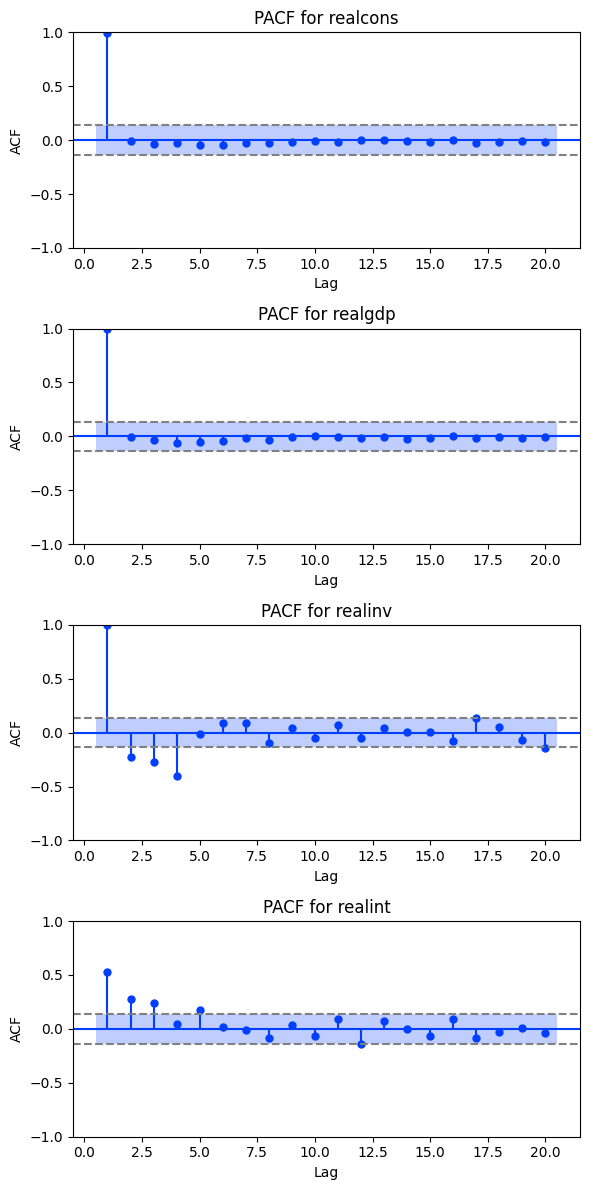

In [ ]:
import statsmodels.graphics.tsaplots as sgt
import matplotlib.pyplot as plt
col_list = ['realcons', 'realgdp', 'realinv','realint']
fig, axes = plt.subplots(nrows=len(col_list), ncols=1, figsize=(6,12))
for i, col in enumerate(col_list):
  sgt.plot_pacf(macro_dataframe[col], lags=20, zero=False, ax=axes[i])
  axes[i].axhline(y=1.96/np.sqrt(len(macro_dataframe[col])), linestyle='--', color='gray')
  axes[i].axhline(y=-1.96/np.sqrt(len(macro_dataframe[col])), linestyle='--', color='gray')
  axes[i].set_title('PACF for %s' % col)
  axes[i].set_xlabel('Lag')
  axes[i].set_ylabel('ACF')
plt.tight_layout()
plt.show()

**PACF plots summary**

**Augmented Dickey Fuller Test**
The Augmented Dickey-Fuller (ADF) test is a statistical hypothesis test commonly used to check the stationarity of a time series.
It tests the null hypothesis that a unit root is present in a time series, indicating that the series is non-stationary.
The ADF test is based on the Dickey-Fuller test, but includes additional lagged differences to account for possible serial correlation in the data.
The test statistic of the ADF test is compared to critical values from a standard normal distribution to determine whether to reject or fail to reject the null hypothesis.
A p-value less than the chosen significance level (usually 0.05) indicates that there is sufficient evidence to reject the null hypothesis and conclude that the time series is stationary.

In [ ]:
import pandas as pd
from statsmodels.tsa.stattools import adfuller
adf_results = pd.DataFrame(columns=['p-value', 'Is the series Stationary?'], index=macro_dataframe.columns)
for col in macro_dataframe.columns:
    result = adfuller(macro_dataframe[col])
    pvalue = result[1]
    if pvalue < 0.05:
        adf_results.loc[col] = [pvalue, True]
    else:
        adf_results.loc[col] = [pvalue, False]
adf_results

,p-value,Is the series Stationary?
realgdp,0.998246,False
realcons,0.997699,False
realinv,0.648496,False
realgovt,0.955841,False
realdpi,1.0,False
cpi,0.990433,False
realint,0.007162,True
unemp,0.106854,False


**Spectral Analysis of Time Series Data before differencing**

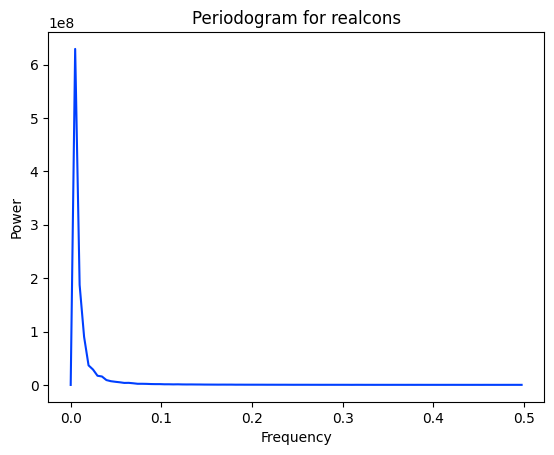

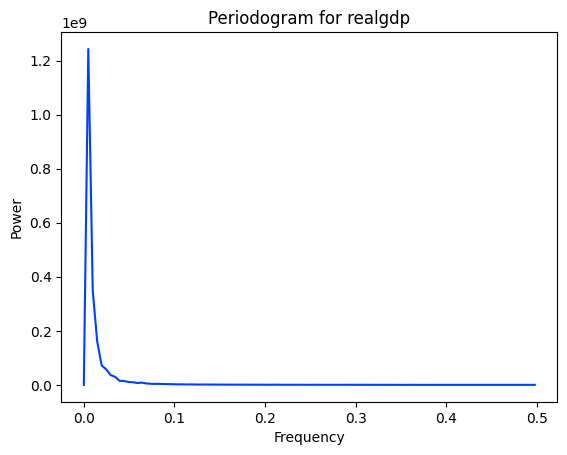

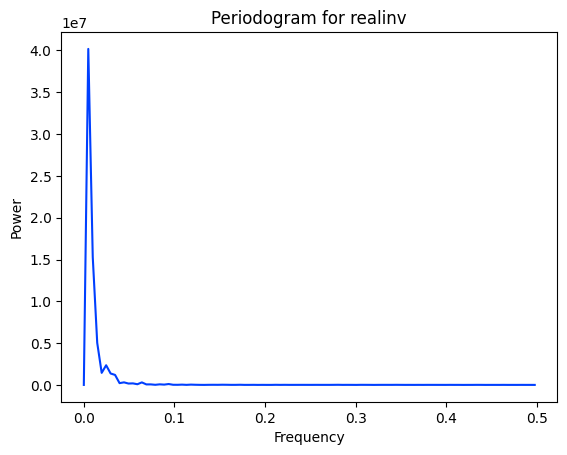

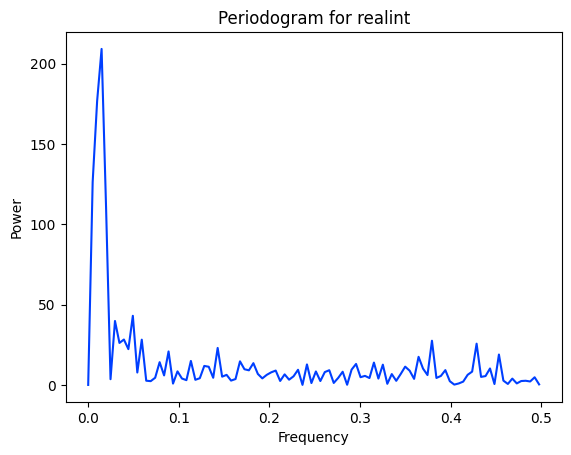

In [ ]:
from scipy.signal import periodogram
col_list = ['realcons', 'realgdp', 'realinv','realint']
for col in col_list:
    f, Pxx = periodogram(macro_dataframe[col])
    plt.plot(f, Pxx)
    plt.title(f'Periodogram for {col}')
    plt.xlabel('Frequency')
    plt.ylabel('Power')
    plt.show()

**Spectral Density**

/usr/local/lib/python3.9/dist-packages/scipy/signal/_spectral_py.py:2014: UserWarning: nperseg = 256 is greater than input length  = 203, using nperseg = 203
  warnings.warn('nperseg = {0:d} is greater than input length '


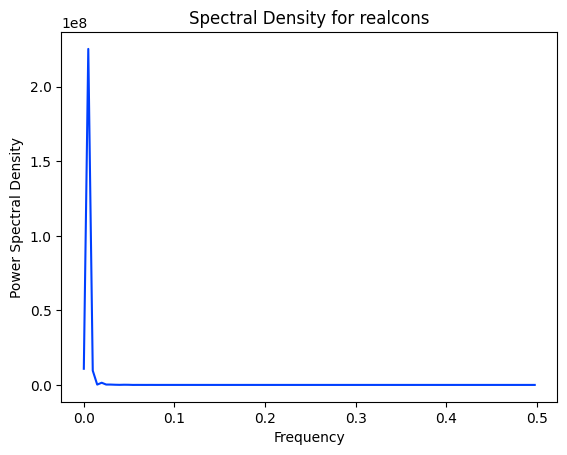

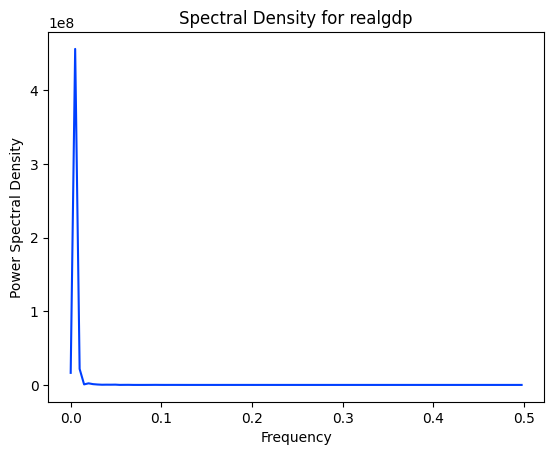

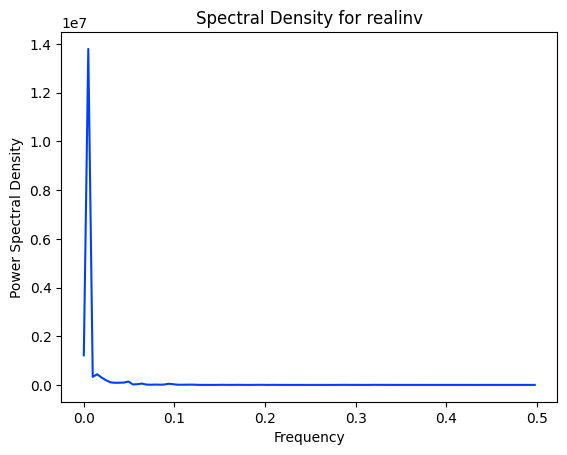

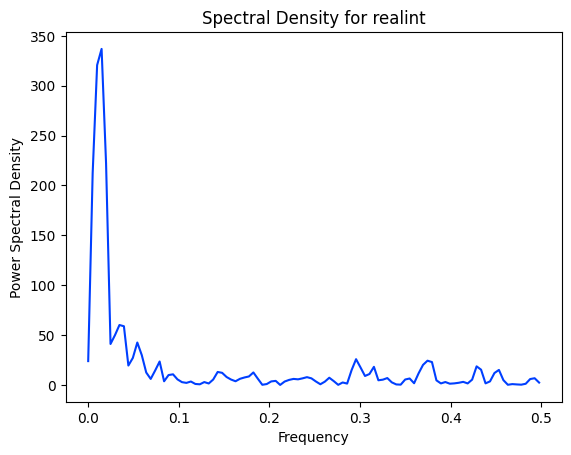

In [ ]:
from scipy.signal import welch
col_list = ['realcons', 'realgdp', 'realinv','realint']
for col in col_list:
    freq, psd = welch(macro_dataframe[col], fs=1, nperseg=256, scaling='density')
    plt.plot(freq, psd)
    plt.title(f'Spectral Density for {col}')
    plt.xlabel('Frequency')
    plt.ylabel('Power Spectral Density')
    plt.show()

Before making Stationary we will split the data into train and test Dataset

In [ ]:
size=int(len(macro_dataframe) * 0.90)
macro_dataframe=macro_dataframe.drop('realint', axis=1)
macro_dataframe_train = macro_dataframe.iloc[:size]
macro_dataframe_test = macro_dataframe.iloc[size:]

In [ ]:
size=int(len(macro_dataframe) * 0.90)
size

182

In [ ]:
macro_dataframe_test.tail()

,realgdp,realcons,realinv,realgovt,realdpi,cpi,unemp
2008-09-30,13324.600,9267.7,1990.693,991.551,9838.3,216.889,6.0
2008-12-31,13141.920,9195.3,1857.661,1007.273,9920.4,212.174,6.9
2009-03-31,12925.410,9209.2,1558.494,996.287,9926.4,212.671,8.1
2009-06-30,12901.504,9189.0,1456.678,1023.528,10077.5,214.469,9.2
2009-09-30,12990.341,9256.0,1486.398,1044.088,10040.6,216.385,9.6


In [ ]:
macro_dataframe_train_log=np.log(macro_dataframe_train)

In [ ]:
macro_dataframe_train_log

,realgdp,realcons,realinv,realgovt,realdpi,cpi,unemp
1959-03-31,7.904833,7.442727,5.659127,6.152828,7.542691,3.366606,1.757858
1959-06-30,7.929775,7.458013,5.739339,6.176493,7.559924,3.372455,1.629241
1959-09-30,7.928582,7.468399,5.667208,6.196974,7.558204,3.379293,1.667707
1959-12-31,7.932076,7.469483,5.701634,6.182192,7.565949,3.379974,1.722767
1960-03-31,7.954267,7.479017,5.804297,6.135996,7.578401,3.385745,1.648659
...,...,...,...,...,...,...,...
2003-06-30,9.370647,9.011621,7.508622,6.731942,9.083926,5.213304,1.824549
2003-09-30,9.387269,9.025468,7.544270,6.732923,9.097776,5.219815,1.808289
2003-12-31,9.396224,9.030974,7.580589,6.740191,9.103468,5.227358,1.757858
2004-03-31,9.403241,9.040453,7.585796,6.752936,9.107854,5.233245,1.740466


**Making Time Series Stationary**


In [ ]:
macro_dataframe_train_diff=(macro_dataframe_train_log).diff().dropna()

In [ ]:
macro_dataframe_train_diff

,realgdp,realcons,realinv,realgovt,realdpi,cpi,unemp
1959-06-30,0.024942,0.015286,0.080213,0.023664,0.017234,0.005849,-0.128617
1959-09-30,-0.001193,0.010386,-0.072131,0.020481,-0.001720,0.006838,0.038466
1959-12-31,0.003495,0.001084,0.034425,-0.014781,0.007745,0.000681,0.055060
1960-03-31,0.022190,0.009534,0.102664,-0.046197,0.012453,0.005772,-0.074108
1960-06-30,-0.004685,0.012572,-0.106694,-0.003900,0.005406,0.000338,0.000000
...,...,...,...,...,...,...,...
2003-06-30,0.007944,0.009252,0.005806,0.047086,0.015000,0.002726,0.049597
2003-09-30,0.016622,0.013846,0.035649,0.000981,0.013850,0.006511,-0.016261
2003-12-31,0.008954,0.005507,0.036319,0.007267,0.005691,0.007543,-0.050431
2004-03-31,0.007017,0.009479,0.005207,0.012745,0.004386,0.005887,-0.017392


**Plotting Time Series of Differenced Dataset**

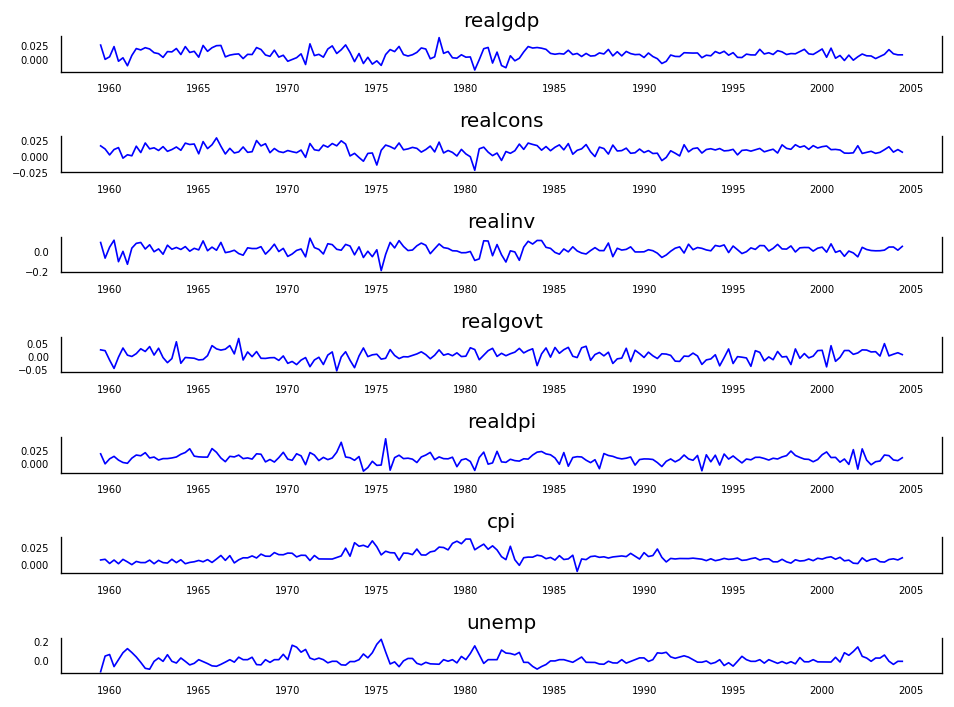

In [ ]:
fig,axes=plt.subplots(nrows=7,ncols=1,dpi=120,figsize=(8,6))
for i,ax in enumerate(axes.flatten()):
    data=macro_dataframe_train_diff[macro_dataframe_train_diff.columns[i]]
    ax.plot(data, color='blue', linewidth=1)
    ax.set_title(macro_dataframe_train_diff.columns[i])
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    ax.spines["top"].set_alpha(0)
    ax.tick_params(labelsize=6)
plt.tight_layout();

**Checking for Stationarity in Time Series**

In [ ]:
import pandas as pd
from statsmodels.tsa.stattools import adfuller
adf_results = pd.DataFrame(columns=['p-value', 'Is the series Stationary?'], index=macro_dataframe_train_diff.columns)
for col in macro_dataframe_train_diff.columns:
    result = adfuller(macro_dataframe_train_diff[col])
    pvalue = result[1]
    if pvalue < 0.05:
        adf_results.loc[col] = [pvalue, True]
    else:
        adf_results.loc[col] = [pvalue, False]
adf_results

,p-value,Is the series Stationary?
realgdp,0.0,True
realcons,0.000013,True
realinv,0.0,True
realgovt,0.001453,True
realdpi,0.0,True
cpi,0.199611,False
unemp,0.000191,True


**ACF and PACF for Differenced Time Series**

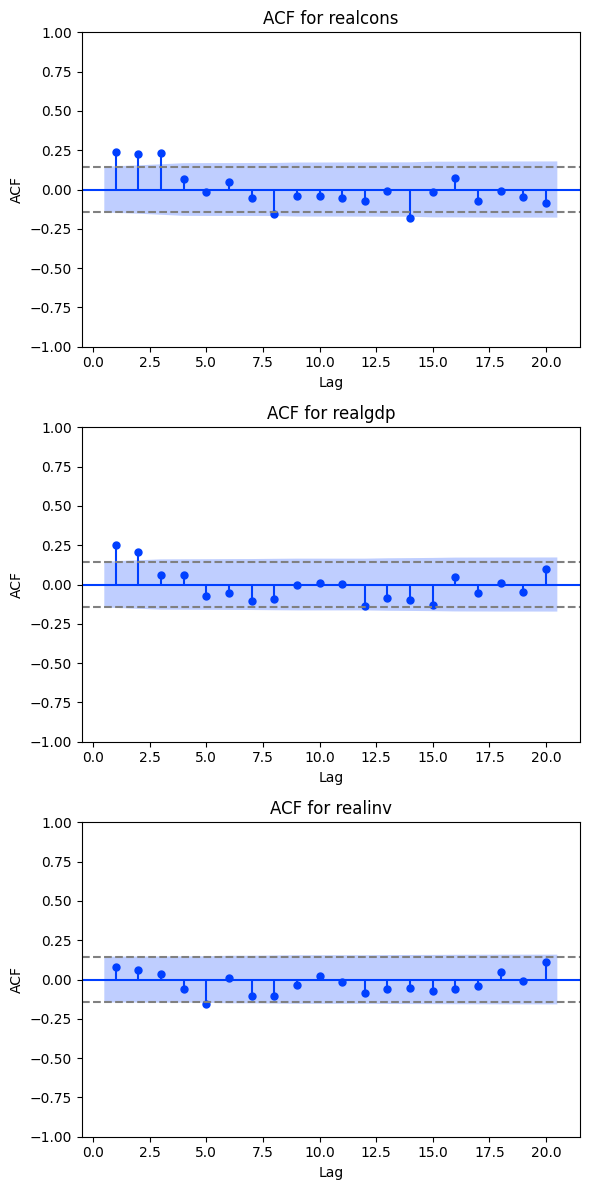

In [ ]:
import statsmodels.graphics.tsaplots as sgt
import matplotlib.pyplot as plt
col_list = ['realcons', 'realgdp', 'realinv']
fig, axes = plt.subplots(nrows=len(col_list), ncols=1, figsize=(6,12))
for i, col in enumerate(col_list):
  sgt.plot_acf(macro_dataframe_train_diff[col], lags=20, zero=False, ax=axes[i])
  axes[i].axhline(y=1.96/np.sqrt(len(macro_dataframe_train_diff[col])), linestyle='--', color='gray')
  axes[i].axhline(y=-1.96/np.sqrt(len(macro_dataframe_train_diff[col])), linestyle='--', color='gray')
  axes[i].set_title('ACF for %s' % col)
  axes[i].set_xlabel('Lag')
  axes[i].set_ylabel('ACF')
plt.tight_layout()
plt.show()

/usr/local/lib/python3.9/dist-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


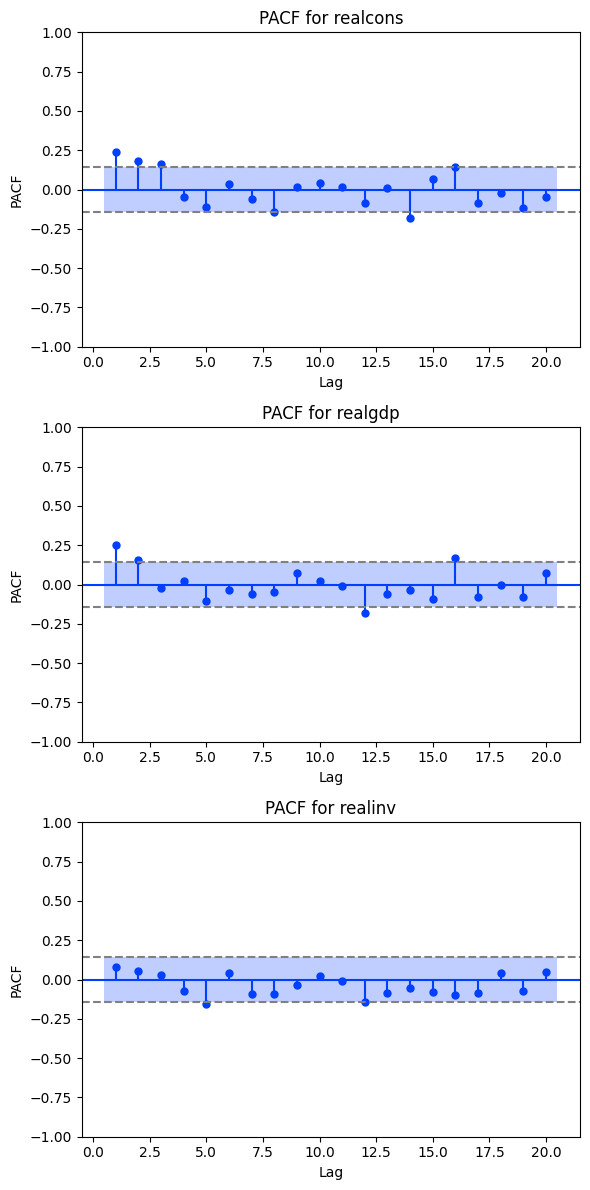

In [ ]:
import statsmodels.graphics.tsaplots as sgt
import matplotlib.pyplot as plt
col_list = ['realcons', 'realgdp', 'realinv']
fig, axes = plt.subplots(nrows=len(col_list), ncols=1, figsize=(6,12))
for i, col in enumerate(col_list):
  sgt.plot_pacf(macro_dataframe_train_diff[col], lags=20, zero=False, ax=axes[i])
  axes[i].axhline(y=1.96/np.sqrt(len(macro_dataframe_train_diff[col])), linestyle='--', color='gray')
  axes[i].axhline(y=-1.96/np.sqrt(len(macro_dataframe_train_diff[col])), linestyle='--', color='gray')
  axes[i].set_title('PACF for %s' % col)
  axes[i].set_xlabel('Lag')
  axes[i].set_ylabel('PACF')
plt.tight_layout()
plt.show()

Spectral Analysis of Differenced Dataset

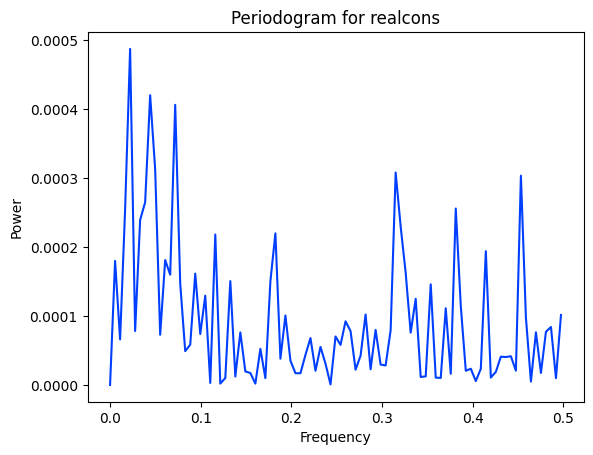

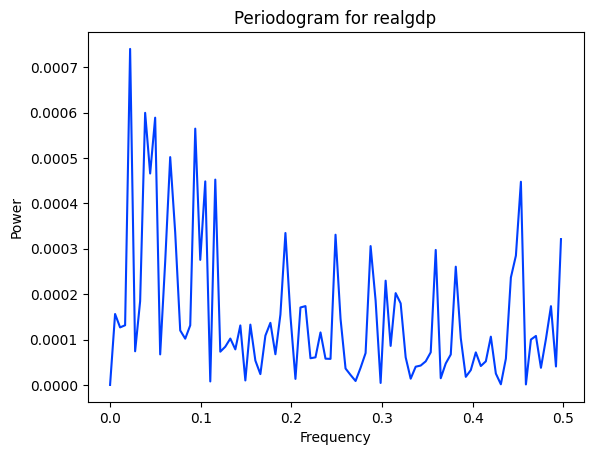

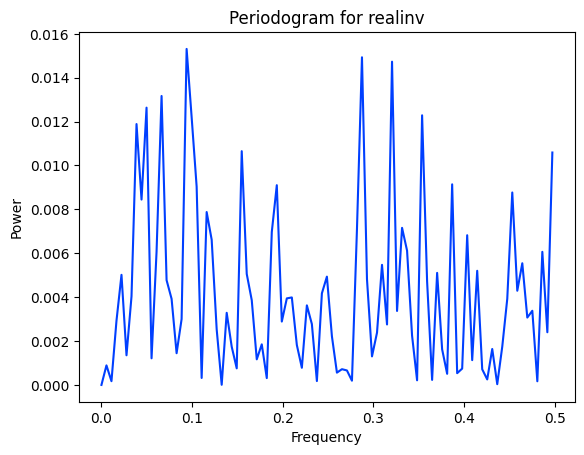

In [ ]:
from scipy.signal import periodogram
col_list = ['realcons', 'realgdp', 'realinv']
for col in col_list:
    f, Pxx = periodogram(macro_dataframe_train_diff[col])
    plt.plot(f, Pxx)
    plt.title(f'Periodogram for {col}')
    plt.xlabel('Frequency')
    plt.ylabel('Power')
    plt.show()

/usr/local/lib/python3.9/dist-packages/scipy/signal/_spectral_py.py:2014: UserWarning: nperseg = 256 is greater than input length  = 181, using nperseg = 181
  warnings.warn('nperseg = {0:d} is greater than input length '


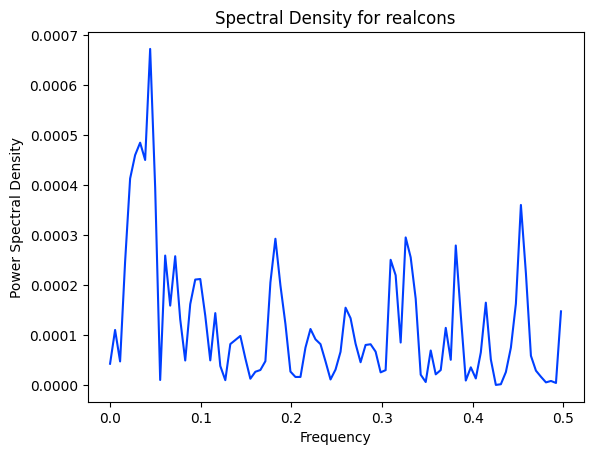

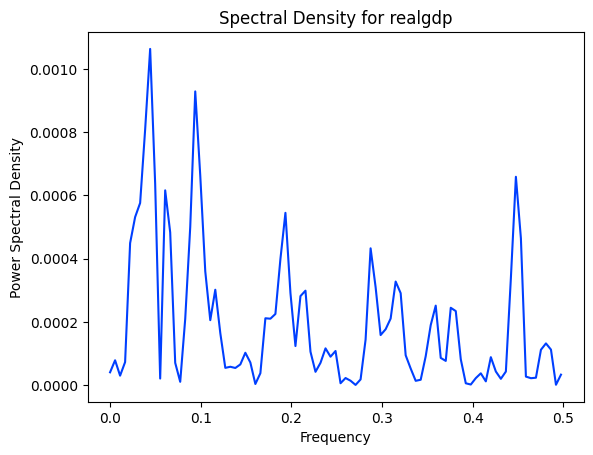

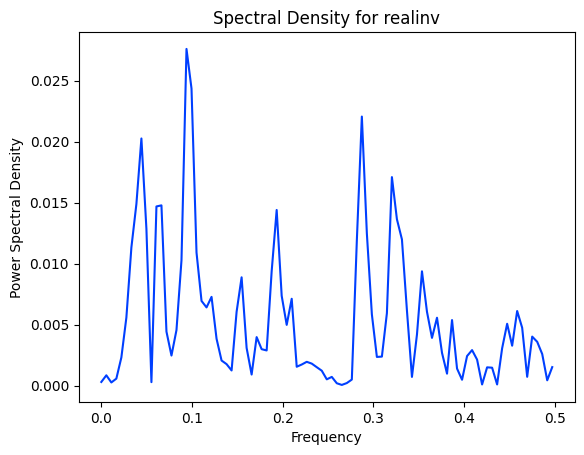

In [ ]:
from scipy.signal import welch
col_list = ['realcons', 'realgdp', 'realinv']
for col in col_list:
    freq, psd = welch(macro_dataframe_train_diff[col], fs=1, nperseg=256, scaling='density')
    plt.plot(freq, psd)
    plt.title(f'Spectral Density for {col}')
    plt.xlabel('Frequency')
    plt.ylabel('Power Spectral Density')
    plt.show()

**Granger's Causality test**

In [ ]:
macro_dataframe_train_diff

,realgdp,realcons,realinv,realgovt,realdpi,cpi,unemp
1959-06-30,0.024942,0.015286,0.080213,0.023664,0.017234,0.005849,-0.128617
1959-09-30,-0.001193,0.010386,-0.072131,0.020481,-0.001720,0.006838,0.038466
1959-12-31,0.003495,0.001084,0.034425,-0.014781,0.007745,0.000681,0.055060
1960-03-31,0.022190,0.009534,0.102664,-0.046197,0.012453,0.005772,-0.074108
1960-06-30,-0.004685,0.012572,-0.106694,-0.003900,0.005406,0.000338,0.000000
...,...,...,...,...,...,...,...
2003-06-30,0.007944,0.009252,0.005806,0.047086,0.015000,0.002726,0.049597
2003-09-30,0.016622,0.013846,0.035649,0.000981,0.013850,0.006511,-0.016261
2003-12-31,0.008954,0.005507,0.036319,0.007267,0.005691,0.007543,-0.050431
2004-03-31,0.007017,0.009479,0.005207,0.012745,0.004386,0.005887,-0.017392


**Calculating maximum lags**
Specifically, the formula suggests that the maximum number of lags (p) should not exceed (T/3)/n, where T is the sample size and n is the number of variables.

In [ ]:
lag = int(((int(len(macro_dataframe_train_diff.index))) / 3) / int(len(macro_dataframe_train_diff.columns)))
lag

8

**Creating a Dataframe and storing results for all the variables**

    The rows are the response variable, columns are predictors. The values in the table 
    are the P-Values. P-Values lesser than the significance level (0.05), implies 
    the Null Hypothesis that the coefficients of the corresponding past values is 
    zero, that is, the X does not cause Y can be rejected.

In [ ]:
maxlag=lag
test = 'ssr_chi2test'
def grangers_causation_matrix(data, variables, test='ssr_chi2test', verbose=False):
  df = pd.DataFrame(np.zeros((len(variables), len(variables))), columns=variables, index=variables)
  for c in df.columns:
      for r in df.index:
          test_result = sts.grangercausalitytests(data[[r, c]], maxlag=maxlag, verbose=False)
          p_values = [round(test_result[i+1][0][test][1],4) for i in range(maxlag)]
          if verbose: print(f'Y = {r}, X = {c}, P Values = {p_values}')
          min_p_value = np.min(p_values)
          df.loc[r, c] = min_p_value
  df.columns = [var + '_x' for var in variables]
  df.index = [var + '_y' for var in variables]
  return df

In [ ]:
 granger=grangers_causation_matrix(macro_dataframe_train_diff, variables = macro_dataframe_train_diff.columns)

In [ ]:
granger

,realgdp_x,realcons_x,realinv_x,realgovt_x,realdpi_x,cpi_x,unemp_x
realgdp_y,1.0000,0.0000,0.0371,0.1696,0.0067,0.0002,0.0002
realcons_y,0.1328,1.0000,0.0497,0.1388,0.0051,0.0000,0.0712
realinv_y,0.0000,0.0000,1.0000,0.1233,0.0013,0.0000,0.0000
realgovt_y,0.3477,0.5222,0.3348,1.0000,0.0100,0.5974,0.1776
realdpi_y,0.0101,0.0000,0.0023,0.1418,1.0000,0.0002,0.0385
cpi_y,0.0001,0.0000,0.1158,0.6324,0.0021,1.0000,0.0003
unemp_y,0.0003,0.0000,0.1691,0.2229,0.0271,0.0000,1.0000


In [ ]:
for column in granger.columns:
    for index, value in granger[column].iteritems():
        if value < 0.05 and index != column:
            print(f"{index} is caused by {column}")

realinv_y is caused by realgdp_x
realdpi_y is caused by realgdp_x
cpi_y is caused by realgdp_x
unemp_y is caused by realgdp_x
realgdp_y is caused by realcons_x
realinv_y is caused by realcons_x
realdpi_y is caused by realcons_x
cpi_y is caused by realcons_x
unemp_y is caused by realcons_x
realgdp_y is caused by realinv_x
realcons_y is caused by realinv_x
realdpi_y is caused by realinv_x
realgdp_y is caused by realdpi_x
realcons_y is caused by realdpi_x
realinv_y is caused by realdpi_x
realgovt_y is caused by realdpi_x
cpi_y is caused by realdpi_x
unemp_y is caused by realdpi_x
realgdp_y is caused by cpi_x
realcons_y is caused by cpi_x
realinv_y is caused by cpi_x
realdpi_y is caused by cpi_x
unemp_y is caused by cpi_x
realgdp_y is caused by unemp_x
realinv_y is caused by unemp_x
realdpi_y is caused by unemp_x
cpi_y is caused by unemp_x


<ipython-input-96-79618e4c72af>:2: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for index, value in granger[column].iteritems():


**Performing VAR directly**

In [ ]:
var_model = VAR(endog=macro_dataframe_train_diff)
res_var = var_model.select_order(maxlags=8, trend='ct')
res_var.summary()

/usr/local/lib/python3.9/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency Q-DEC will be used.
  self._init_dates(dates, freq)


,AIC,BIC,FPE,HQIC
0,-61.99,-61.73,1.198e-27,-61.89
1,-63.38,-62.23*,2.996e-28,-62.91*
2,-63.56,-61.52,2.491e-28,-62.74
3,-63.62*,-60.68,2.382e-28*,-62.43
4,-63.51,-59.68,2.677e-28,-61.96
5,-63.46,-58.74,2.876e-28,-61.55
6,-63.31,-57.70,3.454e-28,-61.04
7,-63.38,-56.87,3.394e-28,-60.74
8,-63.21,-55.81,4.283e-28,-60.20


In [ ]:
var_model = VAR(endog=macro_dataframe_train_diff)
res_var = var_model.select_order(maxlags=8, trend='ct')
res_var.summary()
var_model_fit = var_model.fit(maxlags=3, ic='aic')
var_model_fit.summary()

/usr/local/lib/python3.9/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency Q-DEC will be used.
  self._init_dates(dates, freq)


  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Tue, 25, Apr, 2023
Time:                     00:58:09
--------------------------------------------------------------------
No. of Equations:         7.00000    BIC:                   -60.6566
Nobs:                     178.000    HQIC:                  -62.2931
Log likelihood:           4029.44    FPE:                2.92092e-28
AIC:                     -63.4094    Det(Omega_mle):     1.29196e-28
--------------------------------------------------------------------
Results for equation realgdp
                 coefficient       std. error           t-stat            prob
------------------------------------------------------------------------------
const               0.005259         0.002339            2.248           0.025
L1.realgdp         -0.289437         0.213077           -1.358           0.174
L1.realcons         0.435031         0.173150            2.512    

In [ ]:
var_model_fit = var_model.fit(maxlags=3, ic='aic')
var_model_fit.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Tue, 25, Apr, 2023
Time:                     00:58:09
--------------------------------------------------------------------
No. of Equations:         7.00000    BIC:                   -60.6566
Nobs:                     178.000    HQIC:                  -62.2931
Log likelihood:           4029.44    FPE:                2.92092e-28
AIC:                     -63.4094    Det(Omega_mle):     1.29196e-28
--------------------------------------------------------------------
Results for equation realgdp
                 coefficient       std. error           t-stat            prob
------------------------------------------------------------------------------
const               0.005259         0.002339            2.248           0.025
L1.realgdp         -0.289437         0.213077           -1.358           0.174
L1.realcons         0.435031         0.173150            2.512    

In [ ]:
dw_check_var = durbin_watson(var_model_fit.resid)
for col, val in zip(macro_dataframe_train_diff.columns, dw_check_var):
    print("Durbin-Watson statistic for:")
    print(col, '-->', round(val, 2))
    print("----------------------------")

Durbin-Watson statistic for:
realgdp --> 1.96
----------------------------
Durbin-Watson statistic for:
realcons --> 2.01
----------------------------
Durbin-Watson statistic for:
realinv --> 2.01
----------------------------
Durbin-Watson statistic for:
realgovt --> 2.07
----------------------------
Durbin-Watson statistic for:
realdpi --> 1.96
----------------------------
Durbin-Watson statistic for:
cpi --> 1.96
----------------------------
Durbin-Watson statistic for:
unemp --> 1.88
----------------------------


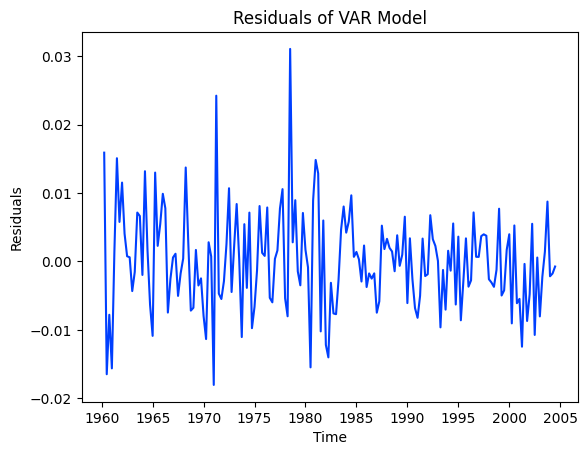

In [ ]:
import matplotlib.pyplot as plt
residuals = var_model_fit.resid
residuals
plt.plot(residuals['realgdp'])
plt.title('Residuals of VAR Model')
plt.xlabel('Time')
plt.ylabel('Residuals')
plt.show()

In [ ]:
from statsmodels.stats.diagnostic import acorr_ljungbox
residuals = var_model_fit.resid
residuals = residuals['realgdp']
lb_test_results = acorr_ljungbox(residuals, lags=[20])
p_value_lb = lb_test_results.iloc[0, 1]
if p_value_lb < 0.05:
    print('The residuals of "realgdp" are not white noise (reject null hypothesis)')
else:
    print('The residuals of "realgdp" are white noise (fail to reject null hypothesis)')


The residuals of "realgdp" are white noise (fail to reject null hypothesis)


In [ ]:
residuals = var_model_fit.resid

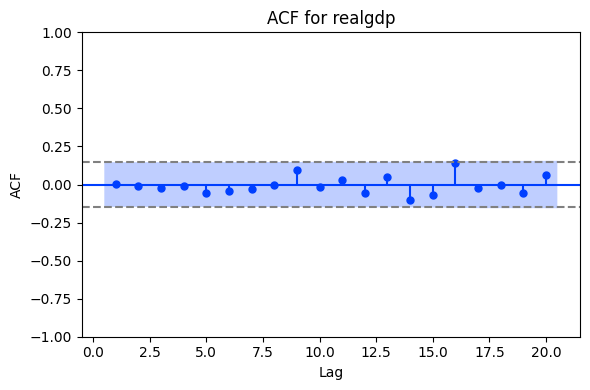

In [ ]:
import statsmodels.graphics.tsaplots as sgt
import matplotlib.pyplot as plt
col = 'realgdp'
fig, ax = plt.subplots(figsize=(6,4))
sgt.plot_acf(residuals[col], lags=20, zero=False, ax=ax)
ax.axhline(y=1.96/np.sqrt(len(residuals[col])), linestyle='--', color='gray')
ax.axhline(y=-1.96/np.sqrt(len(residuals[col])), linestyle='--', color='gray')
ax.set_title('ACF for %s' % col)
ax.set_xlabel('Lag')
ax.set_ylabel('ACF')
plt.tight_layout()
plt.show()

The Durbin-Watson statistic is a test used to detect the presence of autocorrelation in the residuals of a time series model, including a VAR model. The test statistic ranges from 0 to 4, with a value of 2 indicating no autocorrelation, values less than 2 indicating positive autocorrelation, and values greater than 2 indicating negative autocorrelation.

In the context of a VAR model, the Durbin-Watson statistic can be used to test for the presence of autocorrelation in the residuals of the model. If the residuals are found to be autocorrelated, it suggests that the model is not adequately capturing the dynamics of the time series data, and the model may need to be revised or re-specified.

In [ ]:
 #Get the lag order
lag_order = var_model_fit.k_ar
print(lag_order)

3


In [ ]:
 #Input data for forecasting
pred_input = macro_dataframe_train_diff.values[-lag_order:]
pred_input

array([[ 0.0089545 ,  0.00550688,  0.03631883,  0.00726749,  0.00569141,
         0.00754314, -0.05043085],
       [ 0.00701736,  0.00947874,  0.0052074 ,  0.01274534,  0.0043859 ,
         0.00588709, -0.01739174],
       [ 0.00708219,  0.00538983,  0.04251689,  0.00566937,  0.00982319,
         0.00903061, -0.01769958]])

In [ ]:
# Pred input is the value of last to rows that can be used to predict the values further since we have decided lag as 2

In [ ]:
start_date = "2004-09-30"
end_date = "2005-09-30"

In [ ]:
 #Forecasting
var_pred = var_model_fit.forecast(y=pred_input, steps=len(macro_dataframe_test[start_date:end_date]))
df_var_pred = pd.DataFrame(var_pred, index = macro_dataframe_test[start_date:end_date].index, columns = macro_dataframe_train_diff.columns + '_1d')
df_var_pred.tail()

,realgdp_1d,realcons_1d,realinv_1d,realgovt_1d,realdpi_1d,cpi_1d,unemp_1d
2004-09-30,0.008407,0.009072,0.008651,0.005122,0.006494,0.006363,-0.004316
2004-12-31,0.006742,0.008670,-0.000565,0.006496,0.011030,0.006450,0.006609
2005-03-31,0.008786,0.010542,0.009569,0.004034,0.009807,0.006322,-0.001614
2005-06-30,0.009499,0.009911,0.014055,0.004974,0.009224,0.007103,-0.004173
2005-09-30,0.009826,0.010077,0.016713,0.004493,0.008911,0.006817,-0.006247


In [ ]:
df_var_pred.tail()

,realgdp_1d,realcons_1d,realinv_1d,realgovt_1d,realdpi_1d,cpi_1d,unemp_1d
2004-09-30,0.008407,0.009072,0.008651,0.005122,0.006494,0.006363,-0.004316
2004-12-31,0.006742,0.008670,-0.000565,0.006496,0.011030,0.006450,0.006609
2005-03-31,0.008786,0.010542,0.009569,0.004034,0.009807,0.006322,-0.001614
2005-06-30,0.009499,0.009911,0.014055,0.004974,0.009224,0.007103,-0.004173
2005-09-30,0.009826,0.010077,0.016713,0.004493,0.008911,0.006817,-0.006247


In [ ]:
 def invert_transformation(df_train, df_forecast):
    df_fc = df_forecast.copy()
    columns = df_train.columns
    for col in columns:        
      df_fc[str(col)+'_forecast'] = np.log(df_train[col].iloc[-1]) + df_fc[str(col)+'_1d'].cumsum()
    return df_fc

In [ ]:
df_var_pred_inv = invert_transformation(macro_dataframe_train,df_var_pred)
df_var_pred_inv.tail()
df_var_pred_inv = df_var_pred_inv.filter(regex='_forecast$',axis=1)
df_var_pred_inv
df_var_pred_inv = np.exp(df_var_pred_inv) 
df_var_pred_inv

,realgdp_forecast,realcons_forecast,realinv_forecast,realgovt_forecast,realdpi_forecast,cpi_forecast,unemp_forecast
2004-09-30,12316.935441,8560.509765,2073.440352,865.863967,9174.385836,190.307066,5.575884
2004-12-31,12400.255540,8635.051058,2072.269414,871.506773,9276.141810,191.538571,5.612857
2005-03-31,12509.685113,8726.559113,2092.194367,875.029391,9367.563359,192.753393,5.603805
2005-06-30,12629.084222,8813.482158,2121.806885,879.392227,9454.370989,194.127361,5.580467
2005-09-30,12753.794562,8902.748307,2157.567079,883.351798,9538.992191,195.455319,5.545712


In [ ]:
macro_dataframe_test_accuracy_df= macro_dataframe_test[start_date:end_date]

In [ ]:
var_mape = metrics.mean_absolute_percentage_error(macro_dataframe_test_accuracy_df, df_var_pred_inv)
var_model_accuracy = 1 - var_mape
print("The accuracy of the VAR out-of-sample prediction is:")
print(round(var_model_accuracy, 3))

The accuracy of the VAR out-of-sample prediction is:
0.984


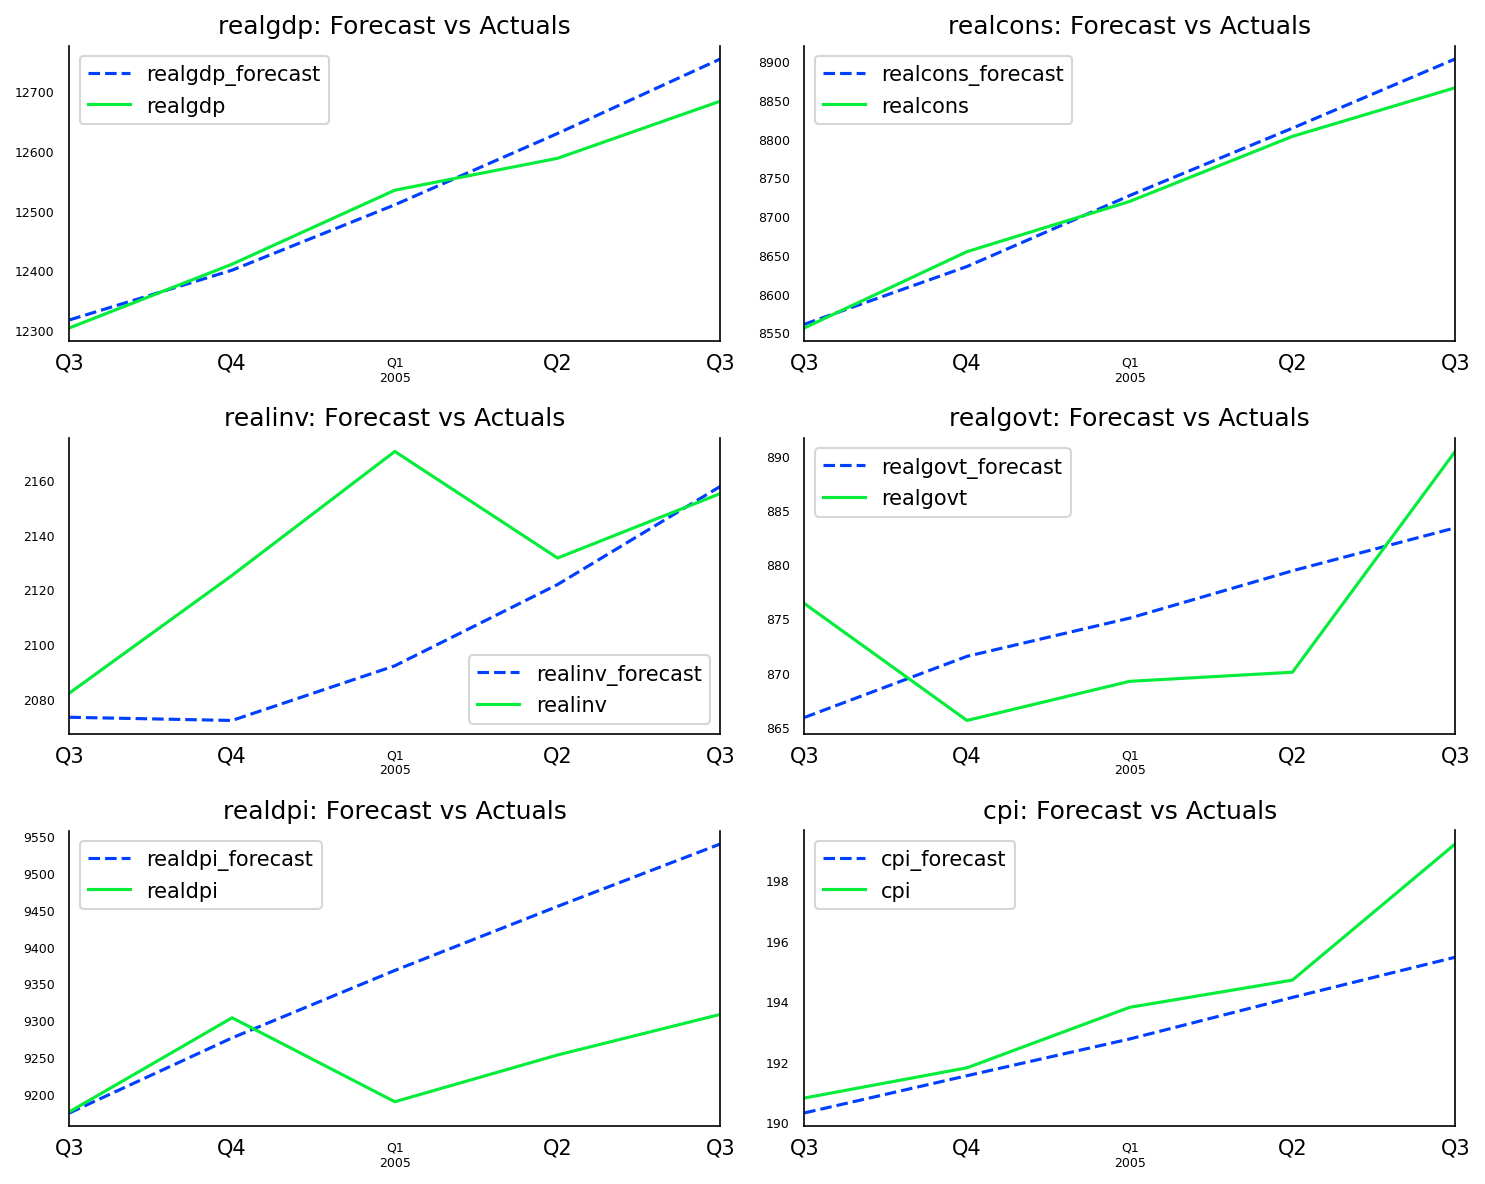

In [ ]:
fig, axes = plt.subplots(nrows=int(len(macro_dataframe_test_accuracy_df.columns)/2), ncols=2, dpi=150, figsize=(10,8))
for i, (col,ax) in enumerate(zip(macro_dataframe_test_accuracy_df.columns, axes.flatten())):
    df_var_pred_inv[col+'_forecast'].plot(legend=True, ax=ax, linestyle='--').autoscale(axis='x',tight=True)
    macro_dataframe_test_accuracy_df[col].plot(legend=True, ax=ax);
    ax.set_title(col + ": Forecast vs Actuals")
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    ax.spines["top"].set_alpha(0)
    ax.tick_params(labelsize=6)

plt.tight_layout();

**Performing Univariate Analysis in real Gdp**

In [ ]:
macro_dataframe_train_diff

,realgdp,realcons,realinv,realgovt,realdpi,cpi,unemp
1959-06-30,0.024942,0.015286,0.080213,0.023664,0.017234,0.005849,-0.128617
1959-09-30,-0.001193,0.010386,-0.072131,0.020481,-0.001720,0.006838,0.038466
1959-12-31,0.003495,0.001084,0.034425,-0.014781,0.007745,0.000681,0.055060
1960-03-31,0.022190,0.009534,0.102664,-0.046197,0.012453,0.005772,-0.074108
1960-06-30,-0.004685,0.012572,-0.106694,-0.003900,0.005406,0.000338,0.000000
...,...,...,...,...,...,...,...
2003-06-30,0.007944,0.009252,0.005806,0.047086,0.015000,0.002726,0.049597
2003-09-30,0.016622,0.013846,0.035649,0.000981,0.013850,0.006511,-0.016261
2003-12-31,0.008954,0.005507,0.036319,0.007267,0.005691,0.007543,-0.050431
2004-03-31,0.007017,0.009479,0.005207,0.012745,0.004386,0.005887,-0.017392


**Checking ACF PACF plots**

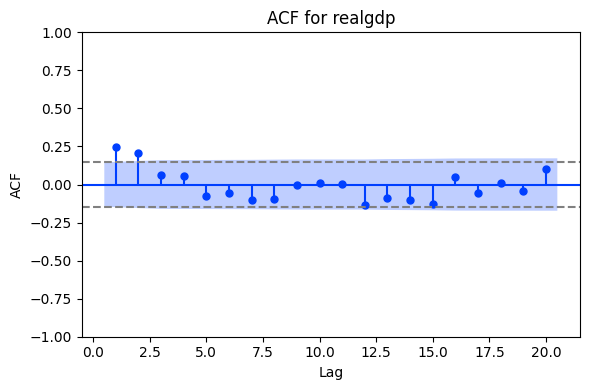

In [ ]:
import statsmodels.graphics.tsaplots as sgt
import matplotlib.pyplot as plt

col = 'realgdp'
fig, ax = plt.subplots(figsize=(6,4))
sgt.plot_acf(macro_dataframe_train_diff[col], lags=20, zero=False, ax=ax)
ax.axhline(y=1.96/np.sqrt(len(macro_dataframe_train_diff[col])), linestyle='--', color='gray')
ax.axhline(y=-1.96/np.sqrt(len(macro_dataframe_train_diff[col])), linestyle='--', color='gray')
ax.set_title('ACF for %s' % col)
ax.set_xlabel('Lag')
ax.set_ylabel('ACF')
plt.tight_layout()
plt.show()

/usr/local/lib/python3.9/dist-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


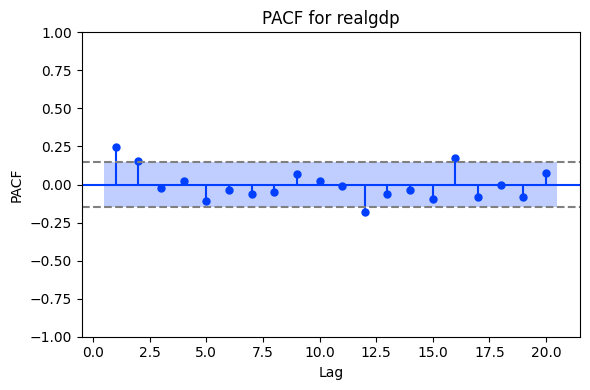

In [ ]:
import statsmodels.graphics.tsaplots as sgt
import matplotlib.pyplot as plt

col = 'realgdp'
fig, ax = plt.subplots(figsize=(6,4))
sgt.plot_pacf(macro_dataframe_train_diff[col], lags=20, zero=False, ax=ax)
ax.axhline(y=1.96/np.sqrt(len(macro_dataframe_train_diff[col])), linestyle='--', color='gray')
ax.axhline(y=-1.96/np.sqrt(len(macro_dataframe_train_diff[col])), linestyle='--', color='gray')
ax.set_title('PACF for %s' % col)
ax.set_xlabel('Lag')
ax.set_ylabel('PACF')
plt.tight_layout()
plt.show()

From the initial analysis AR=1 MA=1 can be a good fit for the data

In [ ]:
macro_dataframe_train_diff['realgdp']

1959-06-30    0.024942
1959-09-30   -0.001193
1959-12-31    0.003495
1960-03-31    0.022190
1960-06-30   -0.004685
                ...   
2003-06-30    0.007944
2003-09-30    0.016622
2003-12-31    0.008954
2004-03-31    0.007017
2004-06-30    0.007082
Name: realgdp, Length: 181, dtype: float64

In [ ]:
import pandas as pd
import numpy as np
from statsmodels.tsa.arima.model import ARIMA
p_range = range(1,4)
q_range = range(1,4)
macro_dataframe_train_diff_arima=macro_dataframe_train_diff.copy()
macro_dataframe_train_diff_arima = macro_dataframe_train_diff_arima.asfreq('Q')
results_df = pd.DataFrame(columns=['p', 'q', 'AIC', 'BIC'])
for p in p_range:
    for q in q_range:
        model = ARIMA(macro_dataframe_train_diff_arima['realgdp'], order=(p, 0, q))
        arima_result = model.fit()
        results_df = results_df.append({'p': p, 'q': q, 
                                        'AIC': arima_result.aic, 
                                        'BIC': arima_result.bic}, ignore_index=True)
results_df        

<ipython-input-120-e09a658d40eb>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'p': p, 'q': q,
<ipython-input-120-e09a658d40eb>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'p': p, 'q': q,
<ipython-input-120-e09a658d40eb>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'p': p, 'q': q,
<ipython-input-120-e09a658d40eb>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'p': p, 'q': q,
<ipython-input-120-e09a658d40eb>:13: FutureWarning: The frame.append method is deprecated and will be removed from panda

,p,q,AIC,BIC
0,1.0,1.0,-1208.044620,-1195.250632
1,1.0,2.0,-1206.786584,-1190.794099
2,1.0,3.0,-1205.041130,-1185.850148
3,2.0,1.0,-1207.635465,-1191.642980
4,2.0,2.0,-1205.686640,-1186.495658
5,2.0,3.0,-1203.761377,-1181.371898
6,3.0,1.0,-1205.602538,-1186.411556
7,3.0,2.0,-1203.326142,-1180.936663
8,3.0,3.0,-1203.123143,-1177.535166


From the AIC BIC as well we can see 1,1 is having the minimum AIC and BIC

In [ ]:
macro_dataframe_arima=macro_dataframe.copy()

type(macro_dataframe_arima)

pandas.core.frame.DataFrame

In [ ]:
macro_dataframe_arima_log=np.log(macro_dataframe_arima)
macro_dataframe_arima_diff=(macro_dataframe_arima_log).diff().dropna()

In [ ]:
macro_dataframe_arima_diff.to_csv('macro_df.csv')

In [ ]:
train = macro_dataframe_arima_diff.iloc[:182]
test = macro_dataframe_arima_diff.iloc[182:186]

In [ ]:
test_exog=test.loc[:, ['realcons', 'realinv', 'realdpi']]

In [ ]:
test_exog_df=test_exog.copy()

In [ ]:
test_exog_df

,realcons,realinv,realdpi
2004-12-31,0.011435,0.020403,0.013799
2005-03-31,0.007460,0.021022,-0.012308
2005-06-30,0.009577,-0.018054,0.006875
2005-09-30,0.007097,0.010956,0.005926


**ARIMAX and SARIMAX**

In [ ]:
# df <- read.csv('macro_df.csv')
# head(df,2)
# realgdp=df$realgdp
# realcons=df$realcons
# realinv=df$realinv
# realdpi=df$realdpi
# #Model Formation
# N = length(realgdp)
# N
# realgdp=ts(realgdp, start=1, end=N)
# realcons=ts(realcons,start=1,end=N)
# realinv=ts(realinv,start=1,end=N)
# realdpi=ts(realdpi,star=1,end=N)
# realcons_lag_1=filter(realcons,c(0,1),sides=1)
# realcons_lag_2=filter(realcons,c(0,0,1),sides=1)
# realinv_lag_1=filter(realinv,c(0,1),sides=1)
# realinv_lag_2=filter(realinv,c(0,0,1),sides=1)
# realdpi_lag_1=filter(realdpi,c(0,1),sides=1)
# realdpi_lag_2=filter(realdpi,c(0,0,1),sides=1)
# realgdp_lag_1=filter(realgdp,c(0,1),sides=1)
# realgdp_lag_2=filter(realgdp,c(0,0,1),sides=1)
# x=cbind(realgdp,realgdp_lag_1,realgdp_lag_2)
# X1=cbind(realgdp_lag_1,realgdp_lag_2,
#          realcons_lag_1,realcons_lag_2,
#          realinv_lag_1,realinv_lag_2,
#          realdpi_lag_1,realdpi_lag_2)
# X2=cbind(realgdp_lag_1,realcons_lag_1,realinv_lag_1,realdpi_lag_1)

# N1 = 182
# X1=X1[1:N1,]
# X2=X2[1:N1,]
# output=realgdp[1:N1]
# results_df <- data.frame()
# ar_values <- 1:3
# ma_values <- 1:3
# for (x in list(X1 = X1, X2 = X2)) {
#   for (ar in ar_values) {
#     for (ma in ma_values) {
#       res <- arima(output,xreg = x,order = c(ar, 0, ma))
#       results_df <- rbind(results_df, data.frame(X = deparse(substitute(x)), AR = ar, MA = ma, AIC = AIC(res), BIC = BIC(res)))
#     }
#   }
# }
# results_df$X[1:9] <- "X1"
# results_df$X[10:18] <- "X2"
# results_df

# arma_11_res<-arima(output,xreg=X1,order=c(1,0,1))
# arma_11_res

# arma_11_res<-arima(output,xreg=X2,order=c(1,0,1))
# arma_11_res

# arma_21_res<-arima(output,xreg=X1,order=c(2,0,1))
# arma_21_res

# arma_21_res<-arima(output,xreg=X2,order=c(2,0,1))
# arma_21_res

# min_AIC_row <- which.min(results_df$AIC)
# min_BIC_row <- which.min(results_df$BIC)
# cat("Row with the lowest AIC:\n")
# print(results_df[min_AIC_row, ])
# cat("\nRow with the lowest BIC:\n")
# print(results_df[min_BIC_row, ])
# arma_21_res<-arima(output,xreg=X2,order=c(2,0,1))
# arma_21_res
# arma_21_residuals=residuals(arma_21_res)
# Box.test(arma_21_residuals,lag=5)
# arma_21_residuals=residuals(arma_21_res)
# plot(arma_21_residuals)
# spectrum(arma_21_residuals[3:N1],log='no')
# acf(arma_21_residuals[3:N1], 15, main="ACF")
# arma_21_res
# #Question.9.Plot the predictions of the model using hypothetical inputs with an R program.
# X2=cbind(realgdp_lag_1,realcons_lag_1,realinv_lag_1,realdpi_lag_1)
# length(X2)
# X_test=X2[182:186,]
# X_test
# y_test=realgdp[182:186]
# y_test

# pr=predict(arma_21_res,newxreg=X_test)
# ts.plot(y_test,pr$pred,lty=1:2,main="Actual vs Predicted GDP")

# mape <- function(actual, predicted) {
#   mean(abs((actual - predicted)/actual))*100
# }


# tolerance <- 0.00
# mape_val <- mape(y_test, pr$pred)
# accuracy_val<-1-(mape_val/100)

# # Print MAPE and Accuracy
# cat("MAPE:", mape_val, "%\n")
# cat("Accuracy within", tolerance*100, "%:", accuracy_val, "%\n")


In [ ]:
# df <- read.csv('macro_df.csv')
# head(df,2)
# realgdp=df$realgdp
# realcons=df$realcons
# realinv=df$realinv
# realdpi=df$realdpi
# #Model Formation
# N = length(realgdp)
# N
# realgdp=ts(realgdp, start=1, end=N,frequency=4)
# realcons=ts(realcons,start=1,end=N,frequency=4)
# realinv=ts(realinv,start=1,end=N,frequency=4)
# realdpi=ts(realdpi,star=1,end=N,frequency=4)
# realcons_lag_1=filter(realcons,c(0,1),sides=1)
# realcons_lag_2=filter(realcons,c(0,0,1),sides=1)
# realinv_lag_1=filter(realinv,c(0,1),sides=1)
# realinv_lag_2=filter(realinv,c(0,0,1),sides=1)
# realdpi_lag_1=filter(realdpi,c(0,1),sides=1)
# realdpi_lag_2=filter(realdpi,c(0,0,1),sides=1)
# realgdp_lag_1=filter(realgdp,c(0,1),sides=1)
# realgdp_lag_2=filter(realgdp,c(0,0,1),sides=1)
# x=cbind(realgdp,realgdp_lag_1,realgdp_lag_2)
# X1=cbind(realgdp_lag_1,realgdp_lag_2,
#          realcons_lag_1,realcons_lag_2,
#          realinv_lag_1,realinv_lag_2,
#          realdpi_lag_1,realdpi_lag_2)
# X2=cbind(realgdp_lag_1,realcons_lag_1,realinv_lag_1,realdpi_lag_1)

# N1 = 182
# X1=X1[1:N1,]
# X2=X2[1:N1,]
# output=realgdp[1:N1]
# results_df <- data.frame()
# ar_values <- 1:3
# ma_values <- 1:3
# for (x in list(X1 = X1, X2 = X2)) {
#   for (ar in ar_values) {
#     for (ma in ma_values) {
#       for (s in 1:3) {
#         res <- arima(output, xreg = x, order = c(ar, 0, ma), seasonal = list(order = c(1, 0, 1), period = 4))
#         results_df <- rbind(results_df, data.frame(X = deparse(substitute(x)), AR = ar, MA = ma, S = s, AIC = AIC(res), BIC = BIC(res)))
#       }
#     }
#   }
# }
# results_df
# results_df$X[1:27] <- "X1"
# results_df$X[28:54] <- "X2"
# results_df

# min_AIC_row <- which.min(results_df$AIC)
# min_BIC_row <- which.min(results_df$BIC)
# cat("Row with the lowest AIC:\n")
# print(results_df[min_AIC_row, ])
# cat("\nRow with the lowest BIC:\n")
# print(results_df[min_BIC_row, ])


# sarima_res<-arima(output,xreg=X2,order=c(2,0,1), seasonal = list(order = c(1,0,1), period = 4))
# sarima_res
# sarima_residuals=residuals(sarima_res)
# Box.test(sarima_residuals,lag=5)
# sarima_residuals=residuals(sarima_res)
# plot(sarima_residuals)


# X2=cbind(realgdp_lag_1,realcons_lag_1,realinv_lag_1,realdpi_lag_1)
# length(X2)
# X_test=X2[182:186,]
# X_test
# y_test=realgdp[182:186]
# y_test

# pr=predict(sarima_res,newxreg=X_test)
# ts.plot(y_test,pr$pred,lty=1:2,main="Actual vs Predicted GDP")

# mape <- function(actual, predicted) {
#   mean(abs((actual - predicted)/actual))*100
# }

# tolerance <- 0.00
# mape_val <- mape(y_test, pr$pred)
# accuracy_val<-1-(mape_val/100)

# # Print MAPE and Accuracy
# cat("MAPE:", mape_val, "%\n")
# cat("Accuracy within", tolerance*100, "%:", accuracy_val, "%\n")

In [ ]:
def invert_transformation_r_arima(df_train, df_forecast):
    df_fc = df_forecast.copy()
    columns = ['realgdp']
    for col in columns:        
      df_fc[str(col)+'_forecast'] = np.log(df_train[col].iloc[-1]) + df_fc[str(col)+'_1d'].cumsum()
    return df_fc
df_arima_op=pd.read_csv('gdp_arima.csv')
df_arima_op=df_arima_op.rename(columns={'x': 'realgdp_1d'})
df_arima_op.index=df_var_pred.index
df_pred_inv_r_arima=invert_transformation_r_arima(macro_dataframe_train,df_arima_op)
df_pred_inv_r_arima
df_pred_inv_r_arima =df_pred_inv_r_arima.filter(regex='_forecast$',axis=1)
df_pred_inv_r_arima
df_pred_inv_r_arima = np.exp(df_pred_inv_r_arima) 
df_pred_inv_r_arima

,realgdp_forecast
2004-09-30,12306.733745
2004-12-31,12415.997696
2005-03-31,12557.490816
2005-06-30,12648.982410
2005-09-30,12758.402733


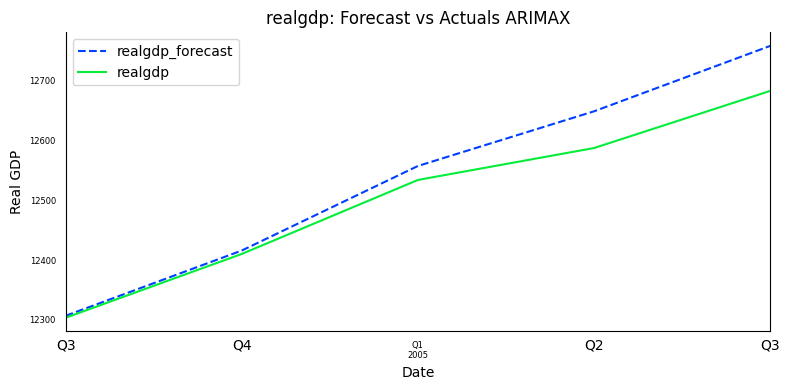

In [ ]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(8, 4))
df_pred_inv_r_arima['realgdp_forecast'].plot(legend=True, ax=ax, linestyle='--')
macro_dataframe_test_accuracy_df['realgdp'].plot(legend=True, ax=ax)
ax.set_title("realgdp: Forecast vs Actuals ARIMAX")
ax.set_xlabel("Date")
ax.set_ylabel("Real GDP")
ax.xaxis.set_ticks_position('none')
ax.yaxis.set_ticks_position('none')
ax.spines["top"].set_alpha(0)
ax.tick_params(labelsize=6)
plt.tight_layout()
plt.show()

In [ ]:
def invert_transformation_r_arima(df_train, df_forecast):
    df_fc = df_forecast.copy()
    columns = ['realgdp']
    for col in columns:        
      df_fc[str(col)+'_forecast'] = np.log(df_train[col].iloc[-1]) + df_fc[str(col)+'_1d'].cumsum()
    return df_fc
df_arima_op=pd.read_csv('gdp_sarima.csv')
df_arima_op=df_arima_op.rename(columns={'x': 'realgdp_1d'})
df_arima_op.index=df_var_pred.index
df_pred_inv_r_arima=invert_transformation_r_arima(macro_dataframe_train,df_arima_op)
df_pred_inv_r_arima
df_pred_inv_r_arima =df_pred_inv_r_arima.filter(regex='_forecast$',axis=1)
df_pred_inv_r_arima
df_pred_inv_r_arima = np.exp(df_pred_inv_r_arima) 
df_pred_inv_r_arima

,realgdp_forecast
2004-09-30,12302.770636
2004-12-31,12399.648033
2005-03-31,12529.683367
2005-06-30,12598.849101
2005-09-30,12696.949895


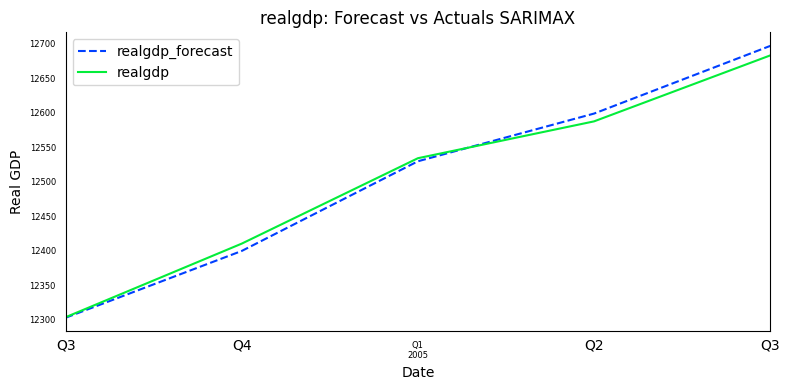

In [ ]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(8, 4))
df_pred_inv_r_arima['realgdp_forecast'].plot(legend=True, ax=ax, linestyle='--')
macro_dataframe_test_accuracy_df['realgdp'].plot(legend=True, ax=ax)
ax.set_title("realgdp: Forecast vs Actuals SARIMAX")
ax.set_xlabel("Date")
ax.set_ylabel("Real GDP")
ax.xaxis.set_ticks_position('none')
ax.yaxis.set_ticks_position('none')
ax.spines["top"].set_alpha(0)
ax.tick_params(labelsize=6)
plt.tight_layout()
plt.show()

**REAL CONS SARIMAX AND ARIMAX**

In [ ]:
# df <- read.csv('macro_df.csv')
# head(df,2)
# realgdp=df$realgdp
# realcons=df$realcons
# realdpi=df$realdpi
# #Model Formation
# N = length(realgdp)
# N
# realgdp=ts(realgdp, start=1, end=N)
# realcons=ts(realcons,start=1,end=N)
# realdpi=ts(realdpi,star=1,end=N)
# realcons_lag_1=filter(realcons,c(0,1),sides=1)
# realcons_lag_2=filter(realcons,c(0,0,1),sides=1)
# realinv_lag_1=filter(realinv,c(0,1),sides=1)
# realinv_lag_2=filter(realinv,c(0,0,1),sides=1)
# realdpi_lag_1=filter(realdpi,c(0,1),sides=1)
# realdpi_lag_2=filter(realdpi,c(0,0,1),sides=1)
# realgdp_lag_1=filter(realgdp,c(0,1),sides=1)
# realgdp_lag_2=filter(realgdp,c(0,0,1),sides=1)
# x=cbind(realcons,realcons_lag_1,realcons_lag_2)
# X1=cbind(realgdp_lag_1,realgdp_lag_2,
#           realdpi_lag_1,realdpi_lag_2,
#          realcons_lag_1,realcons_lag_2)
# X2=cbind(realgdp_lag_1,realcons_lag_1,realdpi_lag_1)

# N1 = 182
# X1=X1[1:N1,]
# X2=X2[1:N1,]
# output=realcons[1:N1]
# results_df <- data.frame()
# ar_values <- 1:3
# ma_values <- 1:3
# for (x in list(X1 = X1, X2 = X2)) {
#   for (ar in ar_values) {
#     for (ma in ma_values) {
#       res <- arima(output,xreg = x,order = c(ar, 0, ma))
#       results_df <- rbind(results_df, data.frame(X = deparse(substitute(x)), AR = ar, MA = ma, AIC = AIC(res), BIC = BIC(res)))
#     }
#   }
# }
# results_df$X[1:9] <- "X1"
# results_df$X[10:18] <- "X2"
# results_df


# min_AIC_row <- which.min(results_df$AIC)
# min_BIC_row <- which.min(results_df$BIC)
# cat("Row with the lowest AIC:\n")
# print(results_df[min_AIC_row, ])
# cat("\nRow with the lowest BIC:\n")
# print(results_df[min_BIC_row, ])
# arma_21_res<-arima(output,xreg=X2,order=c(1,0,1))
# arma_21_res
# arma_21_residuals=residuals(arma_21_res)
# Box.test(arma_21_residuals,lag=5)
# arma_21_residuals=residuals(arma_21_res)
# plot(arma_21_residuals)
# spectrum(arma_21_residuals[3:N1],log='no')
# acf(arma_21_residuals[3:N1], 15, main="ACF")
# arma_21_res

# X2=cbind(realgdp_lag_1,realcons_lag_1,realdpi_lag_1)
# length(X2)
# X_test=X2[182:186,]
# X_test
# y_test=realcons[182:186]
# y_test

# pr=predict(arma_21_res,newxreg=X_test)
# ts.plot(y_test,pr$pred,lty=1:2,main="Actual vs Predicted realcons")

# mape <- function(actual, predicted) {
#   mean(abs((actual - predicted)/actual))*100
# }

# tolerance <- 0.00
# mape_val <- mape(y_test, pr$pred)
# accuracy_val<-1-(mape_val/100)

# # Print MAPE and Accuracy
# cat("MAPE:", mape_val, "%\n")
# cat("Accuracy within", tolerance*100, "%:", accuracy_val, "%\n")


In [ ]:
# df <- read.csv('macro_df.csv')
# head(df,2)
# realgdp=df$realgdp
# realcons=df$realcons
# realinv=df$realinv
# realdpi=df$realdpi
# #Model Formation
# N = length(realgdp)
# N
# realgdp=ts(realgdp, start=1, end=N,frequency=4)
# realcons=ts(realcons,start=1,end=N,frequency=4)
# realinv=ts(realinv,start=1,end=N,frequency=4)
# realdpi=ts(realdpi,star=1,end=N,frequency=4)
# realcons_lag_1=filter(realcons,c(0,1),sides=1)
# realcons_lag_2=filter(realcons,c(0,0,1),sides=1)
# realinv_lag_1=filter(realinv,c(0,1),sides=1)
# realinv_lag_2=filter(realinv,c(0,0,1),sides=1)
# realdpi_lag_1=filter(realdpi,c(0,1),sides=1)
# realdpi_lag_2=filter(realdpi,c(0,0,1),sides=1)
# realgdp_lag_1=filter(realgdp,c(0,1),sides=1)
# realgdp_lag_2=filter(realgdp,c(0,0,1),sides=1)
# x=cbind(realcons,realcons_lag_1,realcons_lag_2)
# X1=cbind(realgdp_lag_1,realgdp_lag_2,
#          realdpi_lag_1,realdpi_lag_2,
#          realcons_lag_1,realcons_lag_2)
# X2=cbind(realgdp_lag_1,realcons_lag_1,realdpi_lag_1)

# N1 = 182
# X1=X1[1:N1,]
# X2=X2[1:N1,]
# output=realcons[1:N1]
# results_df <- data.frame()
# ar_values <- 1:3
# ma_values <- 1:3
# for (x in list(X1 = X1, X2 = X2)) {
#   for (ar in ar_values) {
#     for (ma in ma_values) {
#       for (s in 1:3) {
#         res <- arima(output, xreg = x, order = c(ar, 0, ma), seasonal = list(order = c(1, 0, 1), period = 4))
#         results_df <- rbind(results_df, data.frame(X = deparse(substitute(x)), AR = ar, MA = ma, S = s, AIC = AIC(res), BIC = BIC(res)))
#       }
#     }
#   }
# }
# results_df
# results_df$X[1:27] <- "X1"
# results_df$X[28:54] <- "X2"
# results_df

# min_AIC_row <- which.min(results_df$AIC)
# min_BIC_row <- which.min(results_df$BIC)
# cat("Row with the lowest AIC:\n")
# print(results_df[min_AIC_row, ])
# cat("\nRow with the lowest BIC:\n")
# print(results_df[min_BIC_row, ])


# sarima_res<-arima(output,xreg=X2,order=c(2,0,2), seasonal = list(order = c(1,0,1), period = 4))
# sarima_res
# sarima_residuals=residuals(sarima_res)
# Box.test(sarima_residuals,lag=5)
# sarima_residuals=residuals(sarima_res)
# plot(sarima_residuals)


# X2=cbind(realgdp_lag_1,realcons_lag_1,realdpi_lag_1)
# length(X2)
# X_test=X2[182:186,]
# X_test
# y_test=realcons[182:186]
# y_test

# pr=predict(sarima_res,newxreg=X_test)
# ts.plot(y_test,pr$pred,lty=1:2,main="Actual vs Predicted real cons")

# mape <- function(actual, predicted) {
#   mean(abs((actual - predicted)/actual))*100
# }

# tolerance <- 0.00
# mape_val <- mape(y_test, pr$pred)
# accuracy_val<-1-(mape_val/100)

# # Print MAPE and Accuracy
# cat("MAPE:", mape_val, "%\n")
# cat("Accuracy within", tolerance*100, "%:", accuracy_val, "%\n")

**VARMAX model**

 VARMA model
 Finding otpimal hyper-parameters
 The VARMAX model adds a moving average component to the VAR model, and it can allow for external, or exogenous, variables as well. It must be noted that the VARMAX model does not have a seasonal component. This is not necessarily a problem, as seasonality can be included through the exogenous variables. Since there is no easy way to estimate the best parameters p and q for our VARMA model, we need to create a for loop which iterates through all possible combinations of hyperparameters and then select the optimal ones. We allow for a model with a max of 3 lags for each p and q (since we follow the rule of thumb already discussed in the VAR section for finding max p). We will also assess each combination of trend hyperparameter and see which combination gives us back the lowest AIC value.